In [1]:
import os, sys
sys.path.append("..")

import numpy as np
import IPython.display as ipd
from pathlib import Path

from tensorflow_tts.audio_process import preprocess_wav
from UnetTTS_syn import UnetTTS

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]= "5"

In [3]:
models_and_params = {"duration_param": "../train/configs/unetts_duration.yaml",
                    "duration_model": "../models/duration4k.h5",
                    "acous_param": "../train/configs/unetts_acous.yaml",
                    "acous_model": "../models/acous12k.h5",
                    "vocoder_param": "../train/configs/multiband_melgan.yaml",
                    "vocoder_model": "../models/vocoder800k.h5"}

feats_yaml = "../train/configs/unetts_preprocess.yaml"

text2id_mapper = "../models/unetts_mapper.json"

In [4]:
Tts_handel = UnetTTS(models_and_params, text2id_mapper, feats_yaml)

duration model load finished.
acoustics model load finished.
vocode model load finished.


In [5]:
emotional_src_wav = {"neutral":{"wav": "../test_wavs/neutral.wav",
                                "dur_stat": "../test_wavs/neutral_dur_stat.npy",
                                "text": "现在全城的人都要向我借钱了"},
                     "happy": {"wav": "../test_wavs/happy.wav",
                                "dur_stat": "../test_wavs/happy_dur_stat.npy",
                                "text": "我参加了一个有关全球变暖的集会"},
                     "surprise": {"wav": "../test_wavs/surprise.wav",
                                "dur_stat": "../test_wavs/surprise_dur_stat.npy",
                                "text": "沙尘暴好像给每个人都带来了麻烦"},
                     "angry": {"wav": "../test_wavs/angry.wav",
                                "dur_stat": "../test_wavs/angry_dur_stat.npy",
                                "text": "不管怎么说主队好象是志在夺魁"},
                     "sad": {"wav": "../test_wavs/sad.wav",
                                "dur_stat": "../test_wavs/sad_dur_stat.npy",
                                "text": "我必须再次感谢您的慷慨相助"},
                    }

# 1. Same Text as Reference

- The phoneme duration statistis of reference speech are composed of the initial and vowel of Chinese Pinyin, including their respective mean and standard deviation. They will scale and bias the duration of phonemes and control the speed style of speech.
- dur_stat = [initial_mean, initial_std, vowel_mean, vowel_std],  like dur_stat = [10., 2., 8., 4.]
- The value is the frame length, and the frame shift of this model is 200.
- The accurate value of phoneme duration can be extracted by ASR, MFA and other tools, or the approximate value can be estimated manually.

In [6]:
# change emotion name["neutral", "happy", "surprise", "angry", "sad"]
emotion_type = "sad"
text = emotional_src_wav[emotion_type]["text"]

wav_fpath = Path(emotional_src_wav[emotion_type]["wav"])
src_audio = preprocess_wav(wav_fpath, source_sr=16000, normalize=True, trim_silence=True, is_sil_pad=True,
                    vad_window_length=30,
                    vad_moving_average_width=1,
                    vad_max_silence_length=1)


dur_stat = np.load(emotional_src_wav[emotion_type]["dur_stat"])
print("dur_stat:", dur_stat)

syn_audio, mel_pred, mel_src = Tts_handel.one_shot_TTS(text, src_audio, dur_stat, False)

dur_stat: [10.307693   3.1716197 12.384615   6.0705905]
['wo3', 'bi4', 'xu1', 'zai4', 'ci4', 'gan3', 'xie4', 'nin2', 'de5', 'kang1', 'kai3', 'xiang1', 'zhu4']
phoneme seq: sil ^ uo3 b i4 x v1 z ai4 c ii4 g an3 x ie4 n in2 d e5 k ang1 k ai3 x iang1 zh u4 sil


## Refence_audio

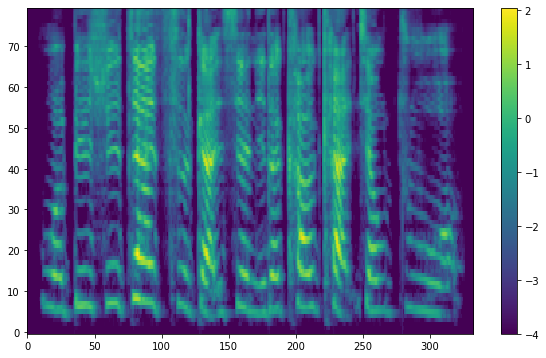

In [7]:
# plt.plot(src_audio)
Tts_handel.feats_handle.melspec_plot(mel_src)
ipd.Audio(src_audio, rate=16000)

## Synthetic audio
- For faster inferencing, the multi-bank melgan vocoder is used here.
- Using other vocoders, such as HiFi-Gan, WaveNet or WaveRNN can improve sound quality.

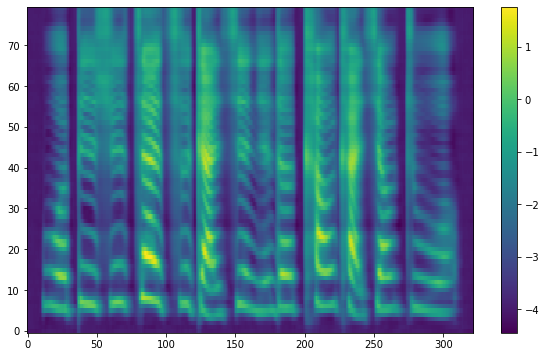

In [8]:
# plt.plot(syn_audio)
Tts_handel.feats_handle.melspec_plot(mel_pred)
ipd.Audio(syn_audio, rate=16000)

# 2. Arbitrary Text

- Because the silence at both ends of the reference audio may cause pronunciation errors at the beginning and end of the generated speech. 
- So we add some characters at both ends of the input text as the new input of the synthesizer. 
- After the synthesis is completed, the audio of the added character is removed from the speech according to their phoneme  frame length.
- Inserting #3 marks into text is regarded as punctuation, and synthetic speech can produce pause.

In [9]:
# Inserting #3 marks into text is regarded as punctuation, and synthetic speech can produce pause.
a_text = "一句话#3风格迁移#3语音合成系统"

dur_stat: [10.307693   3.1716197 12.384615   6.0705905]
['yi1', 'ju4', 'hua4', 'feng1', 'ge2', 'qian1', 'yi2', 'yu3', 'yin1', 'he2', 'cheng2', 'xi4', 'tong3']
phoneme seq: sil ^ i1 j v4 h ua4 #3 f eng1 g e2 q ian1 ^ i2 #3 ^ v3 ^ in1 h e2 ch eng2 x i4 t ong3 sil


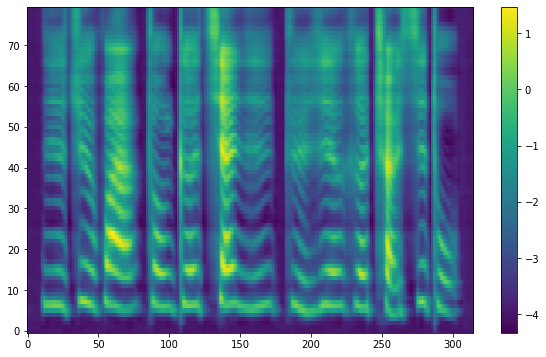

In [10]:
# change emotion name
# emotion_type = "neutral"

wav_fpath = Path(emotional_src_wav[emotion_type]["wav"])
dur_stat = np.load(emotional_src_wav[emotion_type]["dur_stat"])
print("dur_stat:", dur_stat)

src_audio = preprocess_wav(wav_fpath, source_sr=16000, normalize=True, trim_silence=True, is_sil_pad=True,
                    vad_window_length=30,
                    vad_moving_average_width=1,
                    vad_max_silence_length=1)

text = a_text

syn_audio, mel_pred, mel_src = Tts_handel.one_shot_TTS(text, src_audio, dur_stat, True)

# plt.plot(syn_audio)
Tts_handel.feats_handle.melspec_plot(mel_pred)
ipd.Audio(syn_audio, rate=16000)

# 3. Adjust speech speed according to the statistics of phoneme duration

In [11]:
a_text = "一句话#3风格迁移#3语音合成系统"

In [12]:
# change emotion name
# emotion_type = "neutral"

wav_fpath = Path(emotional_src_wav[emotion_type]["wav"])

src_audio = preprocess_wav(wav_fpath, source_sr=16000, normalize=True, trim_silence=True, is_sil_pad=True,
                    vad_window_length=30,
                    vad_moving_average_width=1,
                    vad_max_silence_length=1)

text = a_text

['yi1', 'ju4', 'hua4', 'feng1', 'ge2', 'qian1', 'yi2', 'yu3', 'yin1', 'he2', 'cheng2', 'xi4', 'tong3']
phoneme seq: sil ^ i1 j v4 h ua4 #3 f eng1 g e2 q ian1 ^ i2 #3 ^ v3 ^ in1 h e2 ch eng2 x i4 t ong3 sil


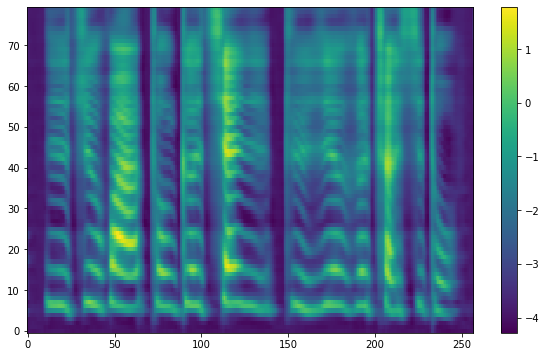

In [13]:
# set dur_stat = None
dur_stat = None # use default dur_stat

syn_audio, mel_pred, mel_src = Tts_handel.one_shot_TTS(text, src_audio, dur_stat, True)

# plt.plot(syn_audio)
Tts_handel.feats_handle.melspec_plot(mel_pred)
ipd.Audio(syn_audio, rate=16000)

['yi1', 'ju4', 'hua4', 'feng1', 'ge2', 'qian1', 'yi2', 'yu3', 'yin1', 'he2', 'cheng2', 'xi4', 'tong3']
phoneme seq: sil ^ i1 j v4 h ua4 #3 f eng1 g e2 q ian1 ^ i2 #3 ^ v3 ^ in1 h e2 ch eng2 x i4 t ong3 sil


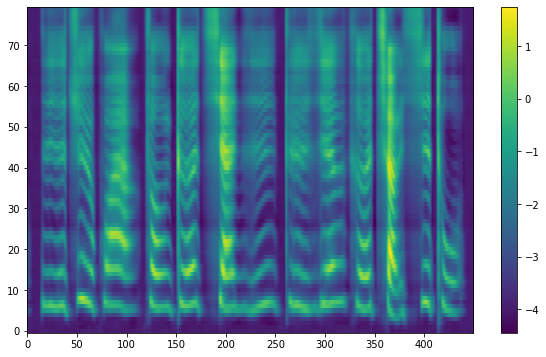

In [14]:
# or set dur_stat = np.array([10, 4, 12, 6])
dur_stat = np.array([15, 6, 18, 9])

syn_audio, mel_pred, mel_src = Tts_handel.one_shot_TTS(text, src_audio, dur_stat, True)

# plt.plot(syn_audio)
Tts_handel.feats_handle.melspec_plot(mel_pred)
ipd.Audio(syn_audio, rate=16000)